In [1]:
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import erfc
from  math import log10, sqrt
#from aff3ct_module import Aff3ctModule

In [10]:
#%% Parameters

k = 8
n = 8
M = 2**k
R = k/n

#nb = 2  #nb bits/symboles (pour comparer avec différentes modulations)

In [11]:
class Normalization2(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self,x):
            y = torch.flatten(x)
            #m = torch.mean(y)
            #s = torch.std(y)
            s = torch.sqrt(torch.mean(y**2))
            x  = x/(sqrt(2)*s)
            
            #print((torch.sqrt(torch.mean(torch.flatten(x)**2))))
            return x

#%% NN
class Normalization(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self,x):
            x = np.sqrt(x.size()[1])*x/(torch.norm(x,dim=1,p=2,keepdim=True))
            return x

class Net(nn.Module):
    def __init__(self, Es_N0_dB):
        super(Net, self).__init__()
        
        self.layer_Relu = nn.Linear(M,M)
        self.layer_linear = nn.Linear(M,n)
        self.set_sigma(Es_N0_dB)

        self.decoder = torch.nn.Sequential(
            nn.Linear(n,M),
            nn.ReLU(),
            nn.Linear(M,M)
        )        

    def encoder(self,x):
        x = torch.relu(self.layer_Relu(x))
        x = self.layer_linear(x)
        
        # Calcule la moyenne et la variance sur tout le codebook
        C = torch.relu(self.layer_Relu(torch.eye(M)))
        C = self.layer_linear(C)
        m = torch.mean(torch.flatten(C))
        s = sqrt(2)*torch.std(torch.flatten(C))
        
        x = (x - m)/s
        return x


        # self.encoder = torch.nn.Sequential(
        #     nn.Linear(M,M),
        #     nn.ReLU(),
        #     nn.Linear(M,n),
        #     Normalization2()
        # )

    def set_sigma(self, Es_N0_dB):
        self.sigma = (1/np.sqrt(2*10**(Es_N0_dB/10)))

    def forward(self,x):
        x = self.encoder(x)
        x = self.channel(x)
        x = self.decoder(x)
        return x

    def channel(self,x):
        sampled_noise = self.sigma*torch.randn(x.size())
        x += sampled_noise
        return x
        
def generate_data(M,batch_size):
    s = np.random.randint(M,size=(batch_size),dtype=np.int64)
    data = torch.zeros([batch_size,M])
    for i in range(batch_size):
        data[i][s[i]]=1
    return data,torch.from_numpy(s)

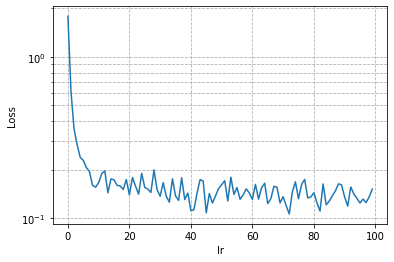

In [12]:
#%% Choosing lr
Eb_N0_dB_train = 7
Es_N0_dB_train = Eb_N0_dB_train + 10*log10(R)
net = Net(Es_N0_dB_train)

n_epochs= 100
batch_size = 1000

L = []
Loss = torch.zeros(n_epochs)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(n_epochs):
    for j in range(100):
        input_data, label = generate_data(M,batch_size)
        output = net(input_data)
        # Backpropagate gradient
        #criterion = nn.MSELoss()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    Const = net.encoder(torch.eye(M))
    L.append(Const)
    Loss[i]=loss

        # Update weights and biases
        #optimizer = optim.SGD(net.parameters(), lr=Lr[i])
        
#Loss_tr = gaussian_filter1d(Loss.detach().numpy(), sigma=5)
Loss_tr = Loss.detach().numpy()
plt.figure()
plt.plot(Loss_tr)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("lr")
plt.grid(True,which="both", linestyle='--')
plt.show()

<class 'numpy.ndarray'>


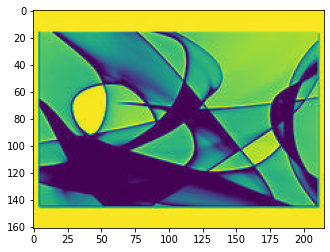

In [13]:

from PIL import Image, ImageOps

im_gray = np.array(Image.open('im2.jpeg'))
im_gray = im_gray[:,:,1]
print(type(im_gray))
# <class 'numpy.ndarray'>
plt.figure
plt.imshow(im_gray)
a_ligne = im_gray.reshape(161*215)

#%%
def de2bin(int,k):
    b= []
    while int!=0:
        b.insert(0,int%2)   
        int = int //2
    if len(b) < k:
        for i in range(k-len(b)):
            b.insert(0,0)
    return b

sequence = []
for k in range(len(a_ligne)):
    bin = de2bin(a_ligne[k],8)
    sequence= sequence+ bin


In [14]:
def bit2dec(L):
    nbr =0
    p= len(L)
    for k in range(p):
        nbr= nbr+L[k]*2**(p-1-k)
    return nbr

bit2dec([1,0,0])

4

In [15]:
#Transmission de l'image
k = 4
sequence_recu = []
for i in range(0,len(sequence)-k+1,k):
    #print([sequence[i:i+k]])
    m = bit2dec(sequence[i:i+k])
    input = torch.zeros([1,M])
    input[0][m] = 1
    output = net.forward(input)
    m_est = torch.argmax(output,dim=1)
    sequence_recu = sequence_recu + de2bin(int(m_est),k)
    

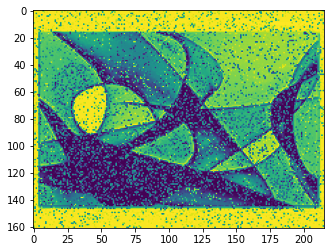

In [9]:
#Reconstruction de l'image
image_ligne = []
for l in range(0,len(sequence_recu),8):
    dec = bit2dec(sequence_recu[l:l+8])
    image_ligne.append(dec) 
image_ligne = np.array(image_ligne)
image = image_ligne.reshape([161,215])
plt.figure
plt.imshow(image)